# BF550 Final Project 

#### R script to run limma package 

In [ ]:
library(limma)
library(GEOquery)
library(dplyr)

#import GEO dataset directly from GEO database using GEOquery 
gene_data <- getGEO("GSE118370", GSEMatrix =TRUE, AnnotGPL=TRUE)
if (length(gene_data) > 1) idx <- grep("GPL570", attr(gene_data, "names")) else idx <- 1
gene_data <- gene_data[[idx]]

# create column names to match toptable matrix
fvarLabels(gene_data) <- make.names(fvarLabels(gene_data))

# group membership for all samples according to disease or normal samples 
gsms <- "011001010101"
sml <- strsplit(gsms, split="")[[1]]

# log2 transformation
ex <- exprs(gene_data)
qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) || 
  (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { ex[which(ex <= 0)] <- NaN
exprs(gene_data) <- log2(ex) }

# set up design matrix by assigning samples to groups 
gs <- factor(sml)
groups <- make.names(c("cancer","normal"))
levels(gs) <- groups
gene_data$group <- gs
design <- model.matrix(~group + 0, gene_data)
colnames(design) <- levels(gs)
fit <- lmFit(gene_data, design)  # fit linear model

# set up contrasts of interest and recalculate model coefficients
cts <- paste(groups[1], groups[2], sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

# compute statistics using eBayes and generate table of differentially expressed genes
fit2 <- eBayes(fit2)
all_genes_tt <- topTable(fit2, adjust = "fdr", number = Inf) #normalize data according to fdr  
all_genes_tt_1 <- select(all_genes_tt, ID, Gene.symbol,Gene.ID, logFC, AveExpr, t, P.Value, adj.P.Val, B)
new_tt <- topTable(fit2,lfc = log2(4), p.value = 0.05, adjust = "fdr", number = Inf)
DEGs <- select(new_tt, ID, Gene.symbol, logFC, AveExpr, t, P.Value, adj.P.Val, B)

write.csv(DEGs, "selected_degs_1.csv") #return data for only DEGs according to parameters specified 
write.csv(all_genes_tt_1, "all_genes.csv") # return data for all genes with p-values and adj p-values 

#### Recreating volcano plot

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# read csv file and import data as a dataframe, rename column names as required 
df2 = pd.read_csv('all_genes.csv')
df2.rename(columns = {'adj.P.Val':'padj', 'Gene.symbol':'symbol', 'P.Value':'pval'}, inplace = True)

#create new column with negative log10 p-values 
df2['nlog10'] = -np.log10(df2.pval)
df2.head()

,Unnamed: 0,ID,symbol,Gene.ID,logFC,AveExpr,t,pval,padj,B,nlog10
0,1563327_a_at,1563327_a_at,LINC01545,724087,-3.865512,5.372024,-12.109463,2.525173e-08,0.000946,8.951309,7.597709
1,204677_at,204677_at,CDH5,1003,-2.495439,10.178252,-11.331786,5.470865e-08,0.000946,8.337435,7.261944
2,230469_at,230469_at,RTKN2,219790,-3.797260,9.474660,-11.196297,6.288114e-08,0.000946,8.224914,7.201480
3,242009_at,242009_at,SLC6A4,6532,-6.180711,10.358953,-10.930990,8.292724e-08,0.000946,7.999546,7.081303
4,204271_s_at,204271_s_at,EDNRB,1910,-3.381801,10.894820,-10.704026,1.055421e-07,0.000946,7.801314,6.976574


Plot while applying logFC and p-value cut-off only

In [12]:
# create subsets for upregulated genes and downregulated genes based on parameters specified in paper 
up_genes_v = df2[(df2.logFC.gt(2)) & (df2.pval.lt(0.05))]
down_genes_v = df2[(df2.logFC.lt(-2)) & (df2.pval.lt(0.05))]

# print length of subsets 
print(len(up_genes_v))
print(len(down_genes_v))

518
1080


In [13]:
#convert ID column from df into a list so we can iterate over it 
up_genes_list = up_genes_v.ID.tolist()
down_genes_list = down_genes_v.ID.tolist()
    
len(up_genes_list)

518

In [14]:
#function to save genes according to expression (upregulated or downregulated)
def map_color(a):
    logFC, ID, nlog10 = a
    
    if abs(logFC) < 2 or nlog10 < (-np.log10(0.05)):
        return 'no change' #return 'no change' if genes are not significantly expressed
    if ID in up_genes_list:
        return 'up' #return 'up' if gene in up_genes_list
    if ID in down_genes_list:
        return 'down'  #return 'down' if gene in down_genes_list

# apply function to dataframe to add a new column for color 
df2['color'] = df2[['logFC', 'ID', 'nlog10']].apply(map_color, axis = 1)

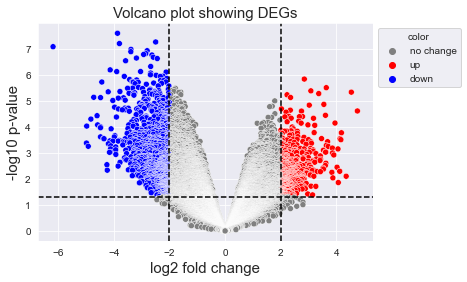

In [63]:
#plot scatterplot using seaborn with DEGs labeled according to downregulation or upregulation
sns.set_style('darkgrid')
fig_v = sns.scatterplot(data = df2, x='logFC', y='nlog10', 
                        hue = 'color', hue_order = ['no change', 'up', 'down'], 
                        palette = ['grey', 'red', 'blue'])

fig_v.axhline(y= (-np.log10(0.05)), c= 'k', linestyle = '--') #add dashed horizontal line for pval cutoff 
fig_v.axvline(x=2, c= 'k', linestyle = '--') #add vertical line for log2fc cutoff
fig_v.axvline(x=-2, c= 'k', linestyle = '--')
sns.move_legend(fig_v, "upper left", bbox_to_anchor=(1, 1)) #format plot, axis labels, and title 
plt.xlabel('log2 fold change', fontsize=15)
plt.ylabel('-log10 p-value', fontsize=15)
fig_v.set_title('Volcano plot showing DEGs', fontsize = 15)

plt.savefig('volcano1.png') #save plot as png file 
plt.show()

Plot while applying logFC, p-value and adj p-value cutoffs

In [22]:
# create subsets for upregulated genes and downregulated genes based on parameters specified in paper 
up_genes_2 = df2[(df2.logFC.gt(2)) & (df2.pval.lt(0.05)) & (df2.padj.lt(0.05))]
down_genes_2 = df2[(df2.logFC.lt(-2)) & (df2.pval.lt(0.05)) & (df2.padj.lt(0.05))]

# print length of subsets
print(len(up_genes_2))
print(len(down_genes_2))

123
514


In [23]:
#convert ID column from df into a list so we can iterate over it 
up_genes_list_2 = up_genes_2.ID.tolist()
down_genes_list_2 = down_genes_2.ID.tolist()

#function to save genes according to expression (upregulated or downregulated)
def map_color_2(b):
    logFC, ID, nlog10 = b
    
    if abs(logFC) < 2 or nlog10 < (-np.log10(0.05)):
        return 'no change' #return 'no change' if genes are not significantly expressed
    if ID in up_genes_list_2:
        return 'up' #return 'up' if gene in up_genes_list_2
    if ID in down_genes_list_2:
        return 'down' #return 'down' if gene in down_genes_list_2
    return 'no change' #return 'no change' if it doesnt satisfy any of the criteria 


#apply function to dataframe, creating new column for color 
df2['color2'] = df2[['logFC', 'ID', 'nlog10']].apply(map_color_2, axis = 1)
df2.head()

,Unnamed: 0,ID,symbol,Gene.ID,logFC,AveExpr,t,pval,padj,B,nlog10,color,color2
0,1563327_a_at,1563327_a_at,LINC01545,724087,-3.865512,5.372024,-12.109463,2.525173e-08,0.000946,8.951309,7.597709,down,down
1,204677_at,204677_at,CDH5,1003,-2.495439,10.178252,-11.331786,5.470865e-08,0.000946,8.337435,7.261944,down,down
2,230469_at,230469_at,RTKN2,219790,-3.797260,9.474660,-11.196297,6.288114e-08,0.000946,8.224914,7.201480,down,down
3,242009_at,242009_at,SLC6A4,6532,-6.180711,10.358953,-10.930990,8.292724e-08,0.000946,7.999546,7.081303,down,down
4,204271_s_at,204271_s_at,EDNRB,1910,-3.381801,10.894820,-10.704026,1.055421e-07,0.000946,7.801314,6.976574,down,down


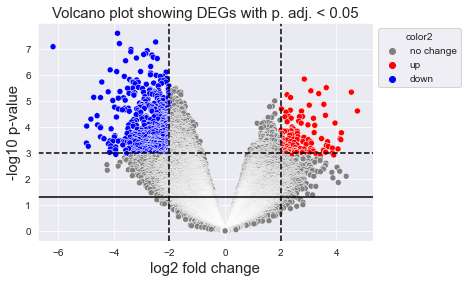

In [64]:
#plot scatterplot using seaborn with DEGs labeled according to downregulation or upregulation
fig_v_2 = sns.scatterplot(data = df2, x='logFC', y='nlog10', 
                        hue = 'color2', hue_order = ['no change', 'up', 'down'], 
                        palette = ['grey', 'red', 'blue'])

fig_v_2.axhline(y= (-np.log10(0.05)), c= 'k', linestyle = '-') #add solid horizontal line for pval cutoff 
fig_v_2.axhline(y= 3, c= 'k', linestyle = '--') #add dashed horizontal line for adj pval cutoff 
fig_v_2.axvline(x=2, c= 'k', linestyle = '--') #add vertical line for log2fc cutoff
fig_v_2.axvline(x=-2, c= 'k', linestyle = '--')
sns.move_legend(fig_v_2, "upper left", bbox_to_anchor=(1, 1)) #format plot and axis labels 
plt.xlabel('log2 fold change', fontsize=15)
plt.ylabel('-log10 p-value', fontsize=15)
fig_v_2.set_title('Volcano plot showing DEGs with p. adj. < 0.05', fontsize = 15)

plt.savefig('volcano2.png') #save plot as png file 
plt.show()

#### Recreating heatmap with hierarchical clustering

In [28]:
import csv

In [32]:
#export file containing data for DEGs as a dataframe 
new_df=pd.read_csv("selected_degs_1.csv")
new_df.keys()

Index(['Unnamed: 0', 'ID', 'Gene.symbol', 'logFC', 'AveExpr', 't', 'P.Value',
       'adj.P.Val', 'B'],
      dtype='object')

In [56]:
#read excel file containing overall expression data and rename columns 
overall_exp = pd.read_excel('overall_expression_data.xlsx')
overall_exp.rename(columns={'ID_REF':'ID'}, inplace=True)
overall_exp.rename(columns={"GSM3325818":"Disease_1","GSM3325819":"Normal_1", "GSM3325820":"Normal_2","GSM3325821":"Disease_2", "GSM3325822" :"Disease_3", "GSM3325823":"Normal_3","GSM3325824":"Disease_4","GSM3325825":"Normal_4","GSM3325826":"Disease_5", "GSM3325827":"Normal_5", "GSM3325828":"Disease_6","GSM3325829":"Normal_6"},inplace=True)
overall_exp.head()

,ID,Disease_1,Normal_1,Normal_2,Disease_2,Disease_3,Normal_3,Disease_4,Normal_4,Disease_5,Normal_5,Disease_6,Normal_6
0,1007_s_at,11.895394,10.269245,10.065805,11.291417,11.802366,10.093049,12.031426,9.846327,11.294818,10.387100,11.358080,10.749565
1,1053_at,6.816687,6.504383,7.179516,3.300399,5.672110,5.181882,6.847892,4.644593,6.263927,5.809992,7.207723,5.339998
2,117_at,10.534546,9.789316,8.632564,8.843515,7.270362,9.016977,8.080441,8.913012,8.722642,8.638038,8.909750,8.693754
3,121_at,7.978451,7.734143,8.765379,8.345526,8.132303,8.127082,8.224374,8.376125,8.483086,8.901374,8.110718,6.559176
4,1255_g_at,7.224958,4.555631,2.431251,2.191050,3.032747,2.649330,3.141635,3.106930,6.371555,2.739549,3.525285,4.641659


In [57]:
#merge df containing DEGs and overall expression data on 'ID' column 
merged_df = pd.merge(new_df, overall_exp, on=['ID'], how='left')
merged_df

,Unnamed: 0,ID,Gene.symbol,logFC,AveExpr,t,P.Value,adj.P.Val,B,Disease_1,...,Normal_2,Disease_2,Disease_3,Normal_3,Disease_4,Normal_4,Disease_5,Normal_5,Disease_6,Normal_6
0,1563327_a_at,1563327_a_at,LINC01545,-3.865512,5.372024,-12.109463,2.525173e-08,0.000946,8.951309,3.119734,...,7.884571,3.768585,3.726142,7.728314,3.373365,7.879256,3.932279,6.951254,2.715499,6.680917
1,204677_at,204677_at,CDH5,-2.495439,10.178252,-11.331786,5.470865e-08,0.000946,8.337435,8.576245,...,11.617961,8.836267,9.159417,11.367052,8.961206,11.316625,9.403835,11.795254,8.646223,11.243467
2,230469_at,230469_at,RTKN2,-3.797260,9.474660,-11.196297,6.288114e-08,0.000946,8.224914,6.379227,...,11.803315,8.501473,7.330779,11.318059,7.664429,10.875235,7.673476,11.907375,7.906795,11.146472
3,242009_at,242009_at,SLC6A4,-6.180711,10.358953,-10.930990,8.292724e-08,0.000946,7.999546,5.748413,...,14.400561,6.552187,7.369221,14.230064,8.888366,12.244497,8.378291,14.058955,6.675105,12.981162
4,204271_s_at,204271_s_at,EDNRB,-3.381801,10.894820,-10.704026,1.055421e-07,0.000946,7.801314,8.285623,...,12.755166,9.002105,9.945448,12.657813,9.276295,12.748679,9.198528,13.274569,9.515520,12.174122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,234764_x_at,234764_x_at,IGLJ3///IGLV1-44///CKAP2///IGLV@///IGLC1,2.213101,9.022521,4.104209,1.314825e-03,0.049137,-0.849526,10.443612,...,7.900717,7.989427,10.896771,7.125955,10.182764,8.020048,9.696117,7.173278,11.565741,8.952467
633,1560300_a_at,1560300_a_at,DMRTC1B///DMRTC1,2.123791,6.358378,4.100297,1.324343e-03,0.049392,-0.856476,7.693043,...,4.560669,8.099833,5.598313,6.163237,7.695581,6.902716,7.585304,4.589712,7.849568,4.937692
634,239548_at,239548_at,NEGR1,-2.974559,5.677795,-4.091858,1.345117e-03,0.049892,-0.871474,2.135958,...,7.260388,2.311835,5.405675,6.202295,5.731724,7.611118,6.419459,7.423243,3.138442,7.434046
635,237390_at,237390_at,ADRA1A,-2.441071,5.694249,-4.091438,1.346159e-03,0.049892,-0.872220,3.274523,...,7.814968,5.416239,5.165667,7.222261,4.703751,7.415576,2.856117,7.699985,5.425986,4.907096


In [58]:
# remove columns not required for plot
heatmap_data=merged_df.drop(["logFC","Gene.symbol","AveExpr","t","P.Value","adj.P.Val","B"], axis=1)
heatmap_data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

heatmap_data

,ID,Disease_1,Normal_1,Normal_2,Disease_2,Disease_3,Normal_3,Disease_4,Normal_4,Disease_5,Normal_5,Disease_6,Normal_6
0,1563327_a_at,3.119734,6.704367,7.884571,3.768585,3.726142,7.728314,3.373365,7.879256,3.932279,6.951254,2.715499,6.680917
1,204677_at,8.576245,11.215470,11.617961,8.836267,9.159417,11.367052,8.961206,11.316625,9.403835,11.795254,8.646223,11.243467
2,230469_at,6.379227,11.189283,11.803315,8.501473,7.330779,11.318059,7.664429,10.875235,7.673476,11.907375,7.906795,11.146472
3,242009_at,5.748413,12.780611,14.400561,6.552187,7.369221,14.230064,8.888366,12.244497,8.378291,14.058955,6.675105,12.981162
4,204271_s_at,8.285623,11.903974,12.755166,9.002105,9.945448,12.657813,9.276295,12.748679,9.198528,13.274569,9.515520,12.174122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,234764_x_at,10.443612,8.323360,7.900717,7.989427,10.896771,7.125955,10.182764,8.020048,9.696117,7.173278,11.565741,8.952467
633,1560300_a_at,7.693043,4.624873,4.560669,8.099833,5.598313,6.163237,7.695581,6.902716,7.585304,4.589712,7.849568,4.937692
634,239548_at,2.135958,7.059358,7.260388,2.311835,5.405675,6.202295,5.731724,7.611118,6.419459,7.423243,3.138442,7.434046
635,237390_at,3.274523,6.428822,7.814968,5.416239,5.165667,7.222261,4.703751,7.415576,2.856117,7.699985,5.425986,4.907096


In [59]:
heatmap_data.to_csv('heatmap_data.csv')

In [60]:
#initialise empty lists to store heatmap data 
data=[]
genes=[]
first=True

with open("heatmap_data.csv") as file: #read csv file, save data as array
    csv_reader=csv.reader(file, delimiter=",")
    for row in csv_reader:
        if first:
            sample_names=row[2:]
            first=False
        else:
            genes.append(row[1])
            data.append(row[2:])
data=np.array(data).astype(float) #save data as np array

data

array([[ 3.119734 ,  6.7043667,  7.8845706, ...,  6.951254 ,  2.7154992,
         6.6809173],
       [ 8.576245 , 11.21547  , 11.617961 , ..., 11.795254 ,  8.646223 ,
        11.243467 ],
       [ 6.3792267, 11.189283 , 11.803315 , ..., 11.907375 ,  7.9067945,
        11.146472 ],
       ...,
       [ 2.1359577,  7.059358 ,  7.260388 , ...,  7.423243 ,  3.1384418,
         7.434046 ],
       [ 3.2745235,  6.4288216,  7.814968 , ...,  7.6999846,  5.4259863,
         4.9070964],
       [ 7.1010303,  7.625117 ,  8.666719 , ...,  7.953331 ,  5.2900558,
         8.120249 ]])

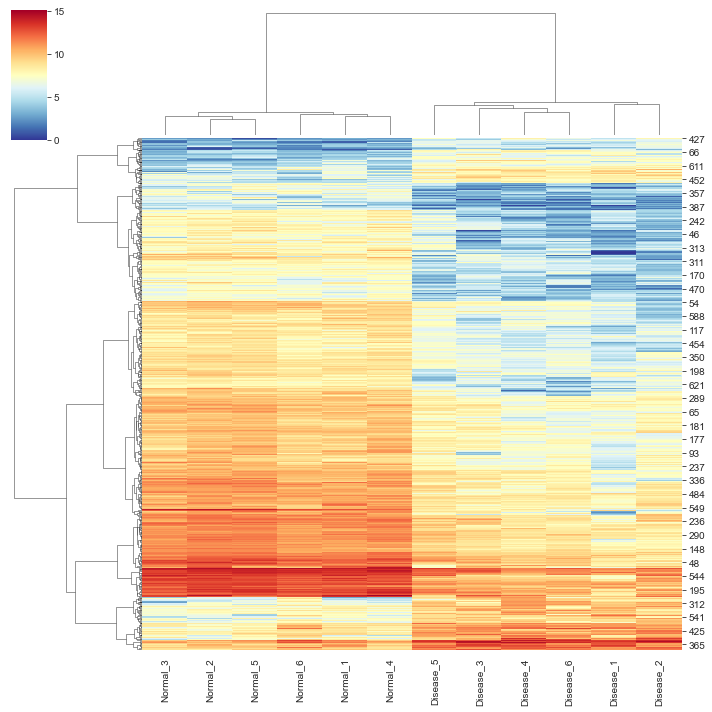

In [62]:
#plot heat map 
sns.clustermap(data, xticklabels=sample_names, method = 'ward', metric = 'euclidean', cmap= 'RdYlBu_r')

plt.savefig('heatmap.png') #save plot as png 
plt.show()